# Eco-evolutionary dynamics in consumer-resource models
Zhijie Feng

Here we use constraint optimization mapping to simualte invasion in consumer-resource models. There are several model choises we can make. Here we allow two types of resource dynamics: MacArthur or linear. And we can choose wherther we allow resource to extinct (permanently), and whether new resource invade simultaneously with consumers.
## Models
MacArthur Consumer-Resource Model
\begin{align*}
    \frac{dX_i}{dt} &= X_i (\sum_\alpha c_{i\alpha} R_\alpha - m_i) \\
    \frac{dR_{\alpha}}{dt} &= R_{\alpha}( k_{\alpha} - R_{\alpha} - \sum_j c_{j \alpha} X_j)
\end{align*}

Linear resource dynamics Consumer-Resource Model
\begin{align*}
    \frac{dX_i}{dt} &= X_i (\sum_\alpha c_{i\alpha} R_\alpha - m_i) \\
    \frac{dR_{\alpha}}{dt} &= k_{\alpha} - R_{\alpha} - \sum_j c_{j \alpha} X_jR_{\alpha}
\end{align*}

In [1]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx
from scipy import stats
import time
import pickle
from collections import  defaultdict
from scipy.sparse import csr_matrix

## Invasion dynamics simulation
Here we construct the class TrajectorySimulator to simulate one invasion trajectory with given input parameters. For each step of the trajectory, a indaver is generated, and invade the ecologically stable ecosystem. Since successful invasion is possible only if invader's immediate growth rate is positive, we check it to reduce computation time. We update the ecosystem by computing the new steady state with the invader added.


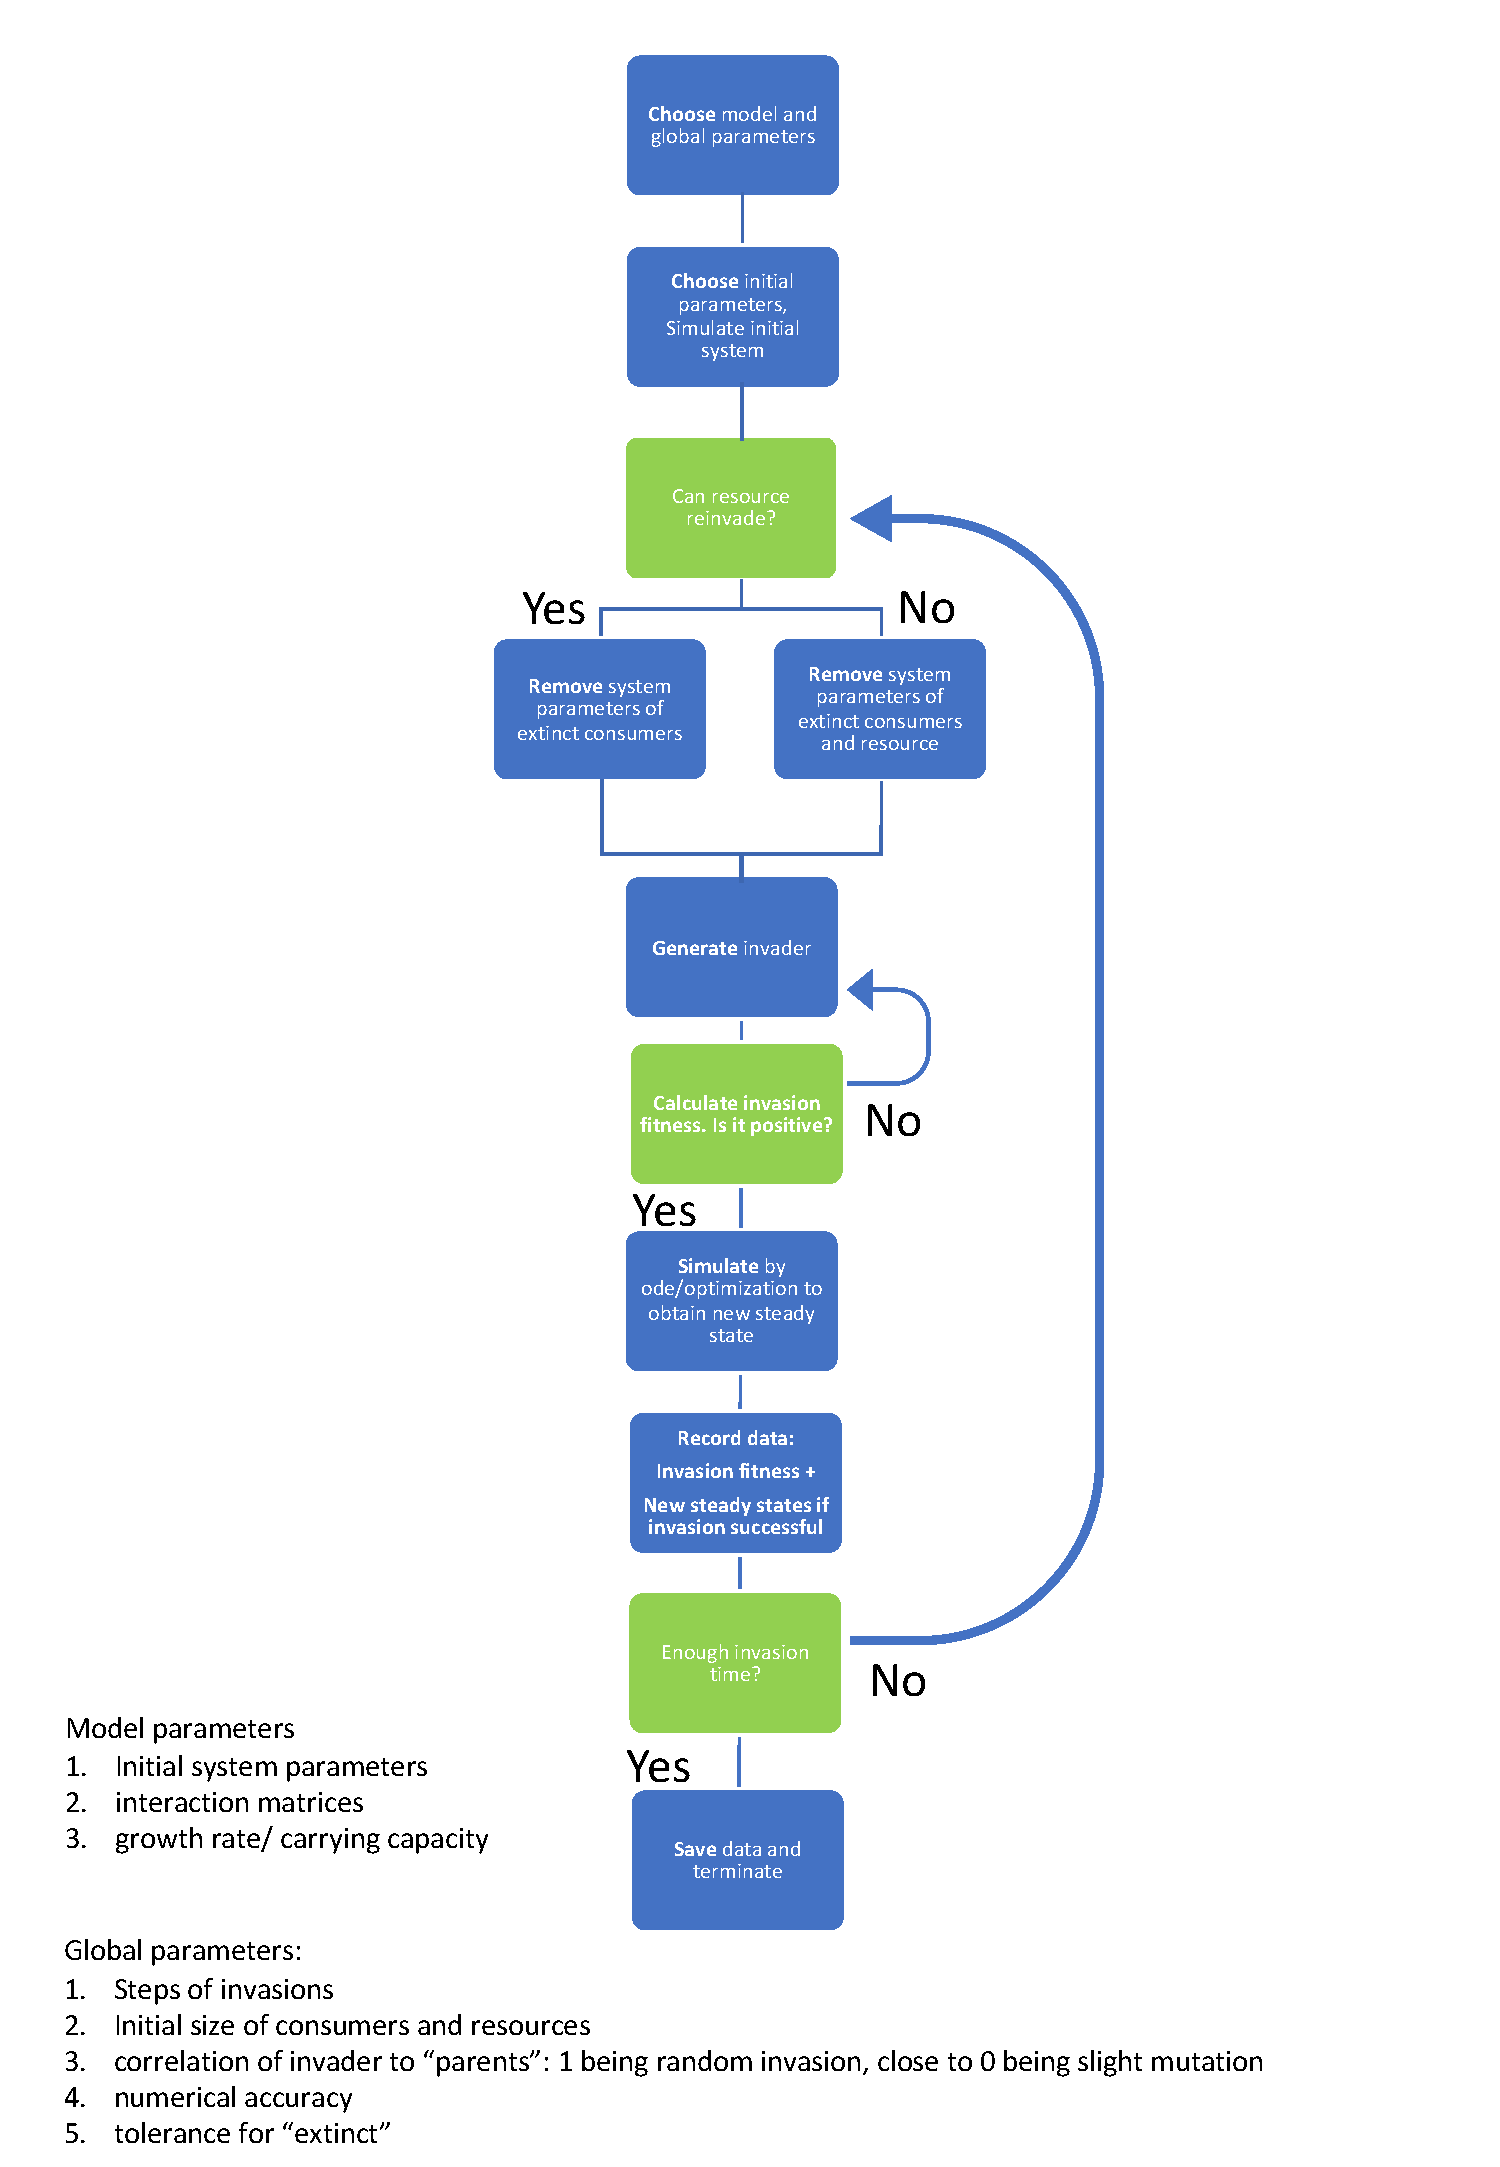

In [2]:
from IPython.display import Image
#cd /Users/zhijie/Documents/GitHub/eco-evolution-simulator
Image("flowchart.png")

In [384]:
class TrajectorySimulator:
    def __init__(self, input_params):
        # Initialize the simulation parameters
        self.top_species = input_params['top_species']
        self.resources = input_params['resources']
        self.mean_k = input_params['mean_k']
        self.sigma_k = input_params['sigma_k']
        self.mean_m = input_params['mean_m']
        self.sigma_m = input_params['sigma_m']
        self.total_invasion = input_params['total_invasion']
        self.resource_dynamics = input_params['resource_dynamics']
        self.resource_extinct = input_params['resource_extinct']
        self.resource_invade = input_params['resource_invade']
        self.mutation_correlation = input_params['mutation_correlation']
        self.mean_c = input_params['mean_c']
        self.sigma_c = input_params['sigma_c']
        self.rho = input_params['asymmetry_correlation']
        #self.niche_density = input_params['niche_density'] #if 1, everyone is generalist, 
        
        # Initialize data storage for simulation results by defaultdict, which automatically initialize dictionary elements with empty lists
        self.results=defaultdict(list) 
        # Save the input parameters in the result too
        self.results['input_params'] = input_params
      

    def initialize_parameters(self):
        # Initialize the consumer and resource matrices and vectors
        self.C =self.mean_c / self.resources + self.sigma_c * np.random.normal(0, 1, (self.top_species, self.resources)) / np.sqrt(self.resources)
        
        # Generate a sparse matrix with normally distributed non-zero elements
        #non_zero_elements =  self.mean_c / self.resources + self.sigma_c * np.random.normal(0, 1, (self.top_species, self.resources)) / np.sqrt(self.resources)
        #non_zero_indices = np.random.rand(self.top_species, self.resources) < self.niche_density

        # Create a sparse matrix
        #self.C = csr_matrix(non_zero_elements * non_zero_indices)
        
        if self.resource_dynamics == 'aMCRM': 
            self.d =  self.sigma_c * np.random.normal(0, 1, (self.top_species, self.resources)) / np.sqrt(self.resources)
            self.results['initial_D']=self.d
        
       # self.C = self.mean_c / self.resources + self.sigma_c * np.random.normal(0, 1, (self.top_species, self.resources)) / np.sqrt(self.resources)
        self.m = np.ones(self.top_species) *self.mean_m + self.sigma_m*np.random.normal(0, 1, self.top_species)
        self.k = np.ones(self.resources) * self.mean_k + self.sigma_k*np.random.normal(0, 1, self.resources)
        
        
        self.results['initial_C']=self.C
        self.results['initial_m']=self.m
        self.results['initial_k']=self.k
        
        
    def initialize_ecosystem(self):
        top_survived=[]
        while  sum(top_survived) <1: #start ecosystem with at least 1 surviving consumer
            self.initialize_parameters()
            N_opt_value, R_opt_value = self.steady_state()
            top_survived, resources_survived = self.determine_survival(N_opt_value,R_opt_value)
        
        self.results['initial_N']=N_opt_value
        self.results['initial_R']=R_opt_value
        self.results['initial_N_survived']=top_survived
        self.results['initial_R_survived']=resources_survived
        self.extinction(top_survived, resources_survived) 
            
        return N_opt_value, R_opt_value, top_survived, resources_survived
         
    def record_results(self, invasion, N_opt_value, R_opt_value, top_survived, resources_survived, invasionC, invasiond, invasionm,invasionR,invasionk,parent_index,parentC,parentm):
        # Record simulation results for the successful invasion
        self.results['successful_index'].append(invasion) # the invasion times that sucessful invasion happened
        self.results['List_packing'].append(sum(top_survived) / sum(resources_survived)) #the ratio of number of surviving consumers over number of surviving consumers
        self.results['List_meanfitness'].append(np.mean(self.C @ self.k - self.m))#the system average of CK-m
        self.results['List_N'].append(N_opt_value) #each data is a list of consumer abundance for each species that survive in the last step, plus final element being the invader  
        self.results['List_R'].append(R_opt_value) #each data is a list of resource abundance for each resources that survive in the last step, plus final element being the invader  
        self.results['List_surviveN'].append(top_survived) #each data is a list of boolean variable, being 1 means the consumer is recognized as survived
        self.results['List_surviveR'].append(resources_survived) #each data is a list of boolean variable, being 1 means the resource is recognized as survived
        self.results['List_parentC'].append(parentC) #parent's consumer perference
        self.results['List_invasionC'].append(invasionC)  #invader's consumer perference
        self.results['List_invasiond'].append(invasiond)  #uncorrelated part of invader's impact
        self.results['List_parentm'].append(parentm) #parent's death rate
        self.results['List_invasionm'].append(invasionm) #invader's death rate
        
        if self.resource_invade:
            self.results['List_invasionR'].append(invasionR) #invader resource's consumer perference
            self.results['List_invasionk'].append(invasionk) #invader resource's carrying capacity
        self.results['parent_indices'].append(parent_index)
        #self.results['testC'].append(self.C) # for testing the reconstruct function in SimulationAnalyzer
        
    def all_invasion_record_results(self,invasion_fitness):
        # Record the result for both any invasions
        self.results['List_invasion_fitness'].append(invasion_fitness) #invasion fitness defined as the immediate growth rate of invader when the it is introduced
            
    def invade(self, R_opt_value, resources_survived, invasionC, invasiond, invasionm, invasionR, invasionk):
        # Add invading species into the model
        #print(self.C)
        #print(invasionC)
        self.C, self.m = np.concatenate((self.C, [invasionC])), np.concatenate((self.m, [invasionm]))
        if self.resource_invade:
            self.C, self.k = np.concatenate((self.C, invasionR), axis=1), np.concatenate((self.k, invasionk))
        if self.rho<1 : self.d = np.concatenate((self.d, [invasiond]))

    def extinction(self, top_survived, resources_survived):
        # Handle species extinction in the model
        if self.resource_extinct:
            self.C, self.m, self.k = self.C[top_survived, :][:, resources_survived], self.m[top_survived], self.k[resources_survived]
        else:
            self.C, self.m = self.C[top_survived, :], self.m[top_survived]
        if self.rho<1 : self.d = self.d[top_survived, :]
    
            
            
    def asymmetric_consumer_resource(t, state):
            X = state[:top_species]
            R = state[top_species:]

            dX = X*(np.dot(C,R)-u)+migration
            dR = R*(k-R-np.dot(E.T,X))+migration

            return np.concatenate((dX,dR),axis=None)


    def steady_state(self):
        # Calculate the steady-state of the model
        R_opt = cvx.Variable(len(self.k))
        
        if self.resource_dynamics == 'MCRM':
            constraints = [self.C @ R_opt <= self.m, R_opt >= 0]
            prob = cvx.Problem(cvx.Minimize(0.5 * cvx.sum_squares(R_opt - self.k)), constraints)
            prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-7, eps_rel=1e-7, max_iter=100000, warm_start=True, verbose=False)
        
        elif self.resource_dynamics == 'linear':
            constraints = [self.C @ R_opt <= self.m, R_opt >= 0]
            prob = cvx.Problem(cvx.Minimize(cvx.sum(cvx.kl_div(self.k + 1e-9, R_opt + 1e-9))), constraints)
            prob_output = prob.solve(solver=cvx.ECOS, abstol=1e-7, reltol=1e-7, warm_start=True, verbose=False, max_iters=100000)
        
        elif self.resource_dynamics == 'aMCRM':
            keff = self.k.copy()
            Delta = 1
            iteration = 0
            ncyc= 0 #number of cycles
            alpha=0.5
            max_iteration = 1000
            Delta_old = 0
            tol=  1e-4
            self.E=self.mean_c / self.resources + self.rho*(self.C-self.mean_c / self.resources)+np.sqrt(1-self.rho**2)*(self.d)
            while Delta > tol and iteration < max_iteration:
                try:
                    R_opt = cvx.Variable(len(keff))
                    constraints = [self.C @ R_opt <= self.m, R_opt >= 0]
                    prob = cvx.Problem(cvx.Minimize(0.5 * cvx.sum_squares(R_opt - keff)), constraints)
                    prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-7, eps_rel=1e-7, max_iter=100000, verbose=False)

                    N_values = prob.constraints[0].dual_value
                    R_values = R_opt.value

                    deltak = self.k + (self.C.T - self.E.T) @ N_values - keff
                    keff += alpha * deltak

                    #keff=self.k + (self.C.T - self.E.T) @ N_values
                    Delta_next=abs(np.max(self.k - R_values - self.E.T @ N_values))
                    if np.isfinite(Delta) and Delta > tol and np.abs(Delta-Delta_old) < 0.1*tol: 
                        print(Delta)
                        ncyc+=1 #check if the different
                    Delta_old=Delta
                    Delta = Delta_next
                    iteration += 1
                    
                except:
                    prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-8, eps_rel=1e-8, max_iter=5000, verbose=True)
                    
                    random_number=np.random.uniform(-1,1)
                    keff=keff+random_number*len(keff)
                
                if ncyc > 10:
                    print('Limit cycle detected, shifted keff')
                    random_number=np.random.uniform(-1,1)
                    keff=keff+random_number*len(keff)
                    ncyc=0
                    #iteration=max_iteration
                if iteration==max_iteration: 
                    self.failed=True
                    print('self.k:',self.k)
                    print('self.E:',self.E)
                    print('self.C:',self.C)
                    print('self.m:',self.m)
                    print(Delta,'iterative optimization failed!!!!')

                    
        return  prob.constraints[0].dual_value, R_opt.value

    def mutation(self, mean_value, parent, mutant):
        # Apply mutation to a species
        return mean_value + self.mutation_correlation * (parent-self.mean_c / self.resources)+ np.sqrt(1-self.mutation_correlation**2) * (mutant)
    
    def get_invasion_fitness(self, invasionC, invasionm, R_opt_value, resources_survived):
        invasion_fitness = invasionC @ R_opt_value[resources_survived] - invasionm if self.resource_extinct else invasionC @ R_opt_value - invasionm
        
        return invasion_fitness
    
    def generate_uncorrelated_part(self,top_survived,resources_survived): #generate the random part of the invader
        if sum(top_survived)>0: niches_dim =np.shape(self.C)[-1] #usually the dimension of C tells the niche dimension, unless no consumer survive
        elif self.resource_extinct: niches_dim = sum(resources_survived)
        else: niches_dim = len(resources_survived)
        
        invasionc = self.sigma_c * np.random.normal(0, 1, niches_dim) / np.sqrt(self.resources)
        
        invasionm = self.sigma_m*np.random.normal(0, 1)
        return invasionc, invasionm
    
    def generate_uncorrelated_new_resource(self,top_survived,resources_survived):
        if sum(top_survived)>0: niches_dim =np.shape(self.C)[0]+1 #usually the dimension of C tells the niche dimension, unless no consumer survive
        else: niches_dim = len(top_survived)+1
        # the +1 comes from the fact that consumers invade
        
        invasionR = self.mean_c / self.resources + self.sigma_c * np.random.normal(0, 1, (niches_dim, 1)) / np.sqrt(self.resources)
        invasionk = self.sigma_k*np.random.normal(0, 1, (1))+self.mean_k
        return invasionR, invasionk
    
       
    def determine_survival(self,N_opt_value,R_opt_value,N_threshold=1e-5, R_threshold=1e-5):
        return N_opt_value > N_threshold, R_opt_value > R_threshold
    
    def run_simulation(self):
        N_opt_value, R_opt_value,top_survived, resources_survived=self.initialize_ecosystem()
        old_N_opt_value = N_opt_value
        List_invasion_fitness = []
        self.failed=False
        for invasion in range(self.total_invasion):
            
                
            parent_index = np.random.randint(len(self.C))
                
            invasionc, invasionm = self.generate_uncorrelated_part(top_survived,resources_survived)
            parentC, parentm=self.C[parent_index], self.m[parent_index]
            invasionC, invasionm = self.mutation(self.mean_c / self.resources, parentC, invasionc), self.mutation(self.mean_m, parentm, invasionm)
            
            
            if self.rho !=1: 
                invasiond, _ = self.generate_uncorrelated_part(top_survived,resources_survived)
                parentD = self.d[parent_index]
                invasionD = self.mutation(self.mean_c / self.resources, parentD, invasiond)
                
            else: invasiond = None
            
            if self.resource_invade: 
                invasionR, invasionk = self.generate_uncorrelated_new_resource(top_survived,resources_survived)
            else: invasionR, invasionk = None, None
                
           
            
            invasion_fitness = self.get_invasion_fitness(invasionC, invasionm, R_opt_value, resources_survived)
            self.all_invasion_record_results(invasion_fitness)
            if self.resource_invade: invadebool=1
            else:
                invadebool = invasion_fitness > 0 #invasion only possible when immediate growth rate is positive
            
            if invadebool:     
                self.invade(R_opt_value, resources_survived, invasionC, invasiond, invasionm, invasionR, invasionk)
                N_opt_value, R_opt_value = self.steady_state() 
                if self.failed: 
                    print('invasion:', invasion)
                    print('len(C):',len(self.C))
                    return self.C, self.E, self.m, self.k
                
                top_survived, resources_survived = self.determine_survival(N_opt_value,R_opt_value)
                self.extinction(top_survived, resources_survived) 
                    
                if not np.array_equal(N_opt_value, old_N_opt_value): # Only record when invasion is successful
                    old_N_opt_value = N_opt_value
                    self.record_results(invasion, N_opt_value, R_opt_value, top_survived, resources_survived,invasionC, invasiond, invasionm, invasionR, invasionk, parent_index, parentC, parentm)
                    
        return self.results

#Here is an easy example to check if the simulation is working
if __name__ == '__main__':
    input_params = {
        'top_species': 1, # initial number of species of consumers
        'resources': 30, # initial number of species of resources
        'mean_k': 15, #mean value of k
        'sigma_k': 0.1, #standard deviation of k
        'mean_m': 1, #mean value of m
        'sigma_m': 0.1, #standard deviation of m
        'total_invasion': 10000, #total number of invasion steps
        'resource_dynamics': 'aMCRM', #type of resource dynamics in the model, it can be 'MCRR' or 'linear'
        'resource_extinct': False, # whether we remove resource permenantly if it extinct in one invasion step
        'resource_invade': False, # whether we simultaneously let resource mutate
        'mutation_correlation': 0.999, # correlation of invader to “parents”: 0 being random invasion, ->1 being slight mutation
        'mean_c' : 1,#mean value of element of C
        'sigma_c' : 1, #standard deviation of element of C
        'asymmetry_correlation': 0.9,
    }
    
    start_time = time.time()
    
    simulator = TrajectorySimulator(input_params)
    oneresult = simulator.run_simulation()
    
    print("--- %s seconds ---" % (time.time() - start_time))


self.k: [14.7727045  14.91715956 15.14637293 14.93052097 15.06505558 15.14872127
 14.85462045 14.94751017 14.8571554  15.25065385 14.94206281 14.72754377
 14.90291317 14.96068766 15.07327552 14.86471007 14.86951873 15.02766144
 15.20144411 15.31694509 15.02684016 15.019441   14.90865807 14.73156435
 15.04312572 14.81967438 14.98805262 15.14585197 15.04379755 14.99507339]
self.E: [[ 3.25245311e-01  1.48637717e-01  1.05757638e-01  1.62034549e-01
  -9.08696126e-02 -1.48250242e-02  1.66686182e-02  3.71230887e-01
  -7.35480997e-02  2.93167367e-02  3.70333949e-02  1.56255405e-01
   4.24242848e-02  5.56702308e-02  3.11767413e-02  1.60923339e-01
  -1.50957452e-01  1.15553927e-01  5.94627376e-02  9.73296776e-02
   8.81605181e-02 -1.57741586e-01  6.46385508e-03  1.86242467e-01
  -2.81957055e-02  5.24478757e-01  1.00224275e-01 -8.34096283e-02
   3.44787348e-02 -1.89332084e-01]
 [ 3.43455356e-01 -7.67701144e-03  1.05570220e-02 -4.69910167e-04
   1.31751104e-01 -7.28810021e-02  2.19950229e-01  2.42

## Case study for aMCRM dynamics
Since iterative optimization sometimtes fail, here we save the last set of ecological model parameters and perform ODE simulation, and attempt the corresponding iterative optimization again

In [385]:
C,E,m,k = oneresult
np.corrcoef(np.ndarray.flatten(C),np.ndarray.flatten(E))

array([[1.        , 0.86294597],
       [0.86294597, 1.        ]])

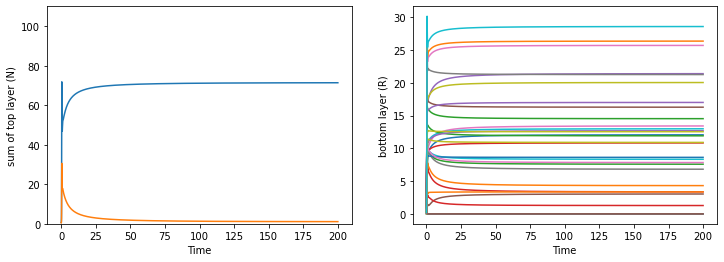

In [393]:

#In case of optimization failure, here we check the ecological dynamics
C,E,m,k = oneresult
top_species=len(C)
resources=len(k)

migration=1e-9
def asymmetric_consumer_resource(t, state):
        X = state[:top_species]
        R = state[top_species:]
        
        dX = X*(np.dot(C,R)-m)+migration
        dR = R*(k-R-np.dot(E.T,X))+migration
        
        return np.concatenate((dX,dR),axis=None)
initial_state = np.random.uniform(0,1,top_species+resources)
sol = solve_ivp(asymmetric_consumer_resource, t_span=[0,200], y0=initial_state.copy(), method='Radau',atol=1e-9,rtol=1e-9)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

#N_opt=prob.constraints[0].dual_value
#for value in N_values:
#       plt.axhline(value,color='grey',ls='--')
plt.plot(sol.t, sol.y[:top_species].T)
plt.xlabel('Time')
plt.ylabel('sum of top layer (N)')
#plt.yscale('log')
plt.ylim(0,110)
plt.subplot(1,2,2)


#for value in R_values:
#       plt.axhline(value,color='grey',ls='--')
          
plt.plot(sol.t, sol.y[top_species:].T)
plt.xlabel('Time')
plt.ylabel('bottom layer (R)')
#plt.yscale('log')

#plt.ylim(5e-1,1.5)
     


plt.show()


In [396]:
keff=k.copy()
Delta=1
max_iteration=1000
iteration=0
alpha=0.5
tol=1e-5
ncyc=0
while Delta>tol and iteration<max_iteration:
    try:
        R_opt = cvx.Variable(len(keff))
        constraints=[C @ R_opt <= m, R_opt >= 0]

        prob = cvx.Problem(cvx.Minimize(0.5*cvx.sum_squares(R_opt-keff)), constraints)
        prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-7, eps_rel=1e-7, max_iter=10000, verbose=False)

        N_values=prob.constraints[0].dual_value
        R_values=R_opt.value


        deltak=k+(C.T-E.T)@N_values-keff
        #keff=k+(C.T-E.T)@N_values
        keff+=alpha*deltak
        
        #Delta=abs(np.max(k-R_values-E.T@N_values))
        Delta_next=np.max(R_values*(k-R_values-E.T@N_values))
        #print(k-R_values-E.T@N_values)
        print(Delta,np.abs(Delta-Delta_old))
        
        if np.isfinite(Delta) and Delta > tol and np.abs(Delta_next-Delta_old) < 0.1*tol: ncyc+=1#prevent limit cycles of ABABAB repeating format
        
        Delta_old=Delta
        Delta=Delta_next
        iteration+=1
    except:
        #If optimization fails, try new initial K 
        print('optimizaer failed, shifted initial K ')
        prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-6, eps_rel=1e-6, max_iter=10000, verbose=True)

        random_number=np.random.uniform(0,1)
        keff=keff+random_number*len(keff)
        
    
    if ncyc > 10:
        print('Limit cycle detected')
        iteration=max_iteration

1 0.9999889817916092
123.15541727933515 122.15541727933515
95.69346713914588 27.461950140189273
68.20648741288367 27.486979726262206
46.53301654655051 21.67347086633316
30.97813719263152 15.554879353918992
20.326561470433788 10.651575722197734
13.220339050418437 7.106222420015351
7.039034919698058 6.181304130720378
2.782590051105861 4.256444868592197
6.279409835354036 3.4968197842481747
4.0859366199666 2.193473215387436
8.23955275312173 4.15361613315513
1.1962662517313645 7.043286501390366
5.767630246647778 4.571363994916414
4.089282054398416 1.678348192249362
8.611518840698652 4.522236786300236
0.49489416502381484 8.116624675674837
2.78903797285743 2.294143807833615
2.0592374007377403 0.7298005721196898
6.7577219767242305 4.69848457598649
2.7605264983891216 3.997195478335109
7.419378159807977 4.658851661418855
1.9415226410979323 5.477855518710045
6.6417263912786755 4.700203750180743
2.9068097653725062 3.7349166259061692
7.556216467674266 4.649406702301759
1.7723803029313945 5.78383616

7.4606801480210105 4.663744266079758
1.8858383789239026 5.574841769097108
6.591416964250179 4.705578585326276
2.9674506825407807 3.6239662817093983
7.6145276642881825 4.647076981747402
1.6992309499531797 5.915296714335003
6.411261317655911 4.712030367702731
3.192050732603774 3.219210585052137
7.825775452555916 4.633724719952141
1.4369111413053948 6.38886431125052
6.161335099954318 4.724423958648924
3.501077367634517 2.660257732319801
8.117391985025415 4.616314617390898
1.0734808524433668 7.043911132582049
5.8151132377203085 4.741632385276942
3.928191941876395 1.8869212958439134
8.51999583416082 4.591803892284425
0.5706814285331897 7.94931440562763
3.5205677525936436 2.949886324060454
2.599653012707237 0.9209147398864066
7.275180754321575 4.675527741614338
2.115539120475145 5.15964163384643
6.809989641804627 4.6944505213294825
2.696518056386745 4.113471585417882
7.358352085892128 4.661834029505384
2.0176370418590177 5.340715044033111
6.7138401550804545 4.696203113221436
2.81763385683909

2.8947800252059035 2.415378082191488
2.1374353269468696 0.7573446982590339
6.839975376621355 4.702540049674486
2.653562397721058 4.1864129789002975
7.32111472042399 4.6675523227029325
2.061724539713963 5.259390180710027
6.75698726290972 4.695262723195757
2.763386119041676 3.993601143868044
7.420931978386718 4.657545859345042
1.940322628986949 5.480609349399769
6.640152007755568 4.699829378768619
2.9090319345365594 3.731120073219009
7.558156893561791 4.649124959025231
1.770069358762427 5.788087534799364
6.478175039676568 4.708105680914141
3.1095772009404192 3.368597838736149
7.74768786133752 4.638110660397102
1.5342573931735541 6.213430468163966
6.253907944861109 4.719650551687555
3.3867902475891305 2.8671176972719787
8.009512130091347 4.622721882502216
1.2080419003104514 6.801470229780895
5.9433353639033095 4.735293463592858
3.7701201092612466 2.173215254642063
8.3710697487835 4.600949639522253
0.7568040332307152 7.614265715552785
4.796044151745705 4.03924011851499
3.5418697378899 1.25

2.34156656969366 4.75661111251377
7.020660456293327 4.6790938865996665
2.437729611572558 4.582930844720769
7.111819514303773 4.674089902731215
2.324639270328566 4.7871802439752065
7.004610165922901 4.679970895594335
2.4576356622837348 4.546974503639166
7.130685104899752 4.673049442616017
2.3012281147667806 4.829456990132972
6.982410062298159 4.681181947531378
2.485166103791807 4.497243958506353
7.156773959298984 4.671607855507176
2.268849424989551 4.887924534309432
6.951702700907065 4.682853275917514
2.523241092094474 4.428461608812591
7.192850217372912 4.669609125278438
2.2240680506314945 4.968782166741417
6.909225950979301 4.685157900347806
2.5758990907044077 4.333326860274893
7.242734402499723 4.666835311795316
2.1621327920672875 5.080601610432435
6.850464910010201 4.688332117942913
2.6487250322116074 4.201739877798594
7.311705888020151 4.662980855808543
2.0764720570227273 5.235233830997423
6.7691690644175 4.692697007394774
2.7494423101062577 4.019726754311243
7.407057548133936 4.65

7.387906421578159 4.668386607458038
1.975979613256213 5.411926808321946
6.677216684072222 4.701237070816008
2.8611345862987347 3.816082097773487
7.514037308191644 4.652902721892909
1.824184302190875 5.689853006000769
6.530051876216296 4.705867574025421
3.0451283193986614 3.484923556817635
7.6869367093263055 4.641808389927644
1.6097796750055424 6.077157034320763
6.325810315112378 4.716030640106835
3.2979151236165896 3.027895191495788
7.9256238620272255 4.627708738410636
1.3125982143792267 6.613025647647999
6.042931703181888 4.730333488802661
3.64725499410148 2.395676709080408
8.255249910535227 4.607994916433746
0.901445132443575 7.353804778091652
5.651058031484952 4.749612899041377
4.130295273007525 1.520762758477427
8.71025328432947 4.579958011321945
0.3326917150369552 8.377561569292515
1.8886593367036641 1.5559676216667089
1.3943834763024163 0.4942758604012478
6.138605182405724 4.744221706103308
3.5180364467608762 2.620568735644848
8.139924924352899 4.621888477592023
1.041191372932274

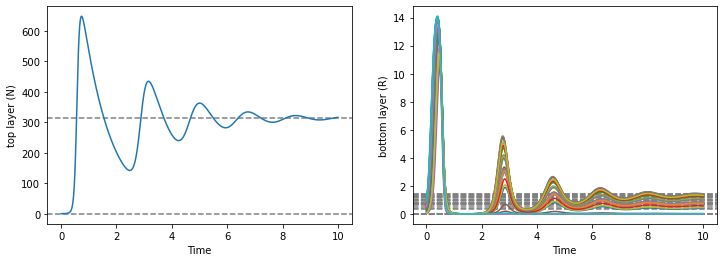

In [132]:

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)

for value in N_values:
       plt.axhline(value,color='grey',ls='--')
plt.plot(sol.t, np.sum(sol.y[:top_species].T,axis=1))
plt.xlabel('Time')
plt.ylabel('top layer (N)')
#plt.yscale('log')

plt.subplot(1,2,2)


for value in R_values:
       plt.axhline(value,color='grey',ls='--')
          
plt.plot(sol.t, sol.y[top_species:].T)
plt.xlabel('Time')
plt.ylabel('bottom layer (R)')
#plt.yscale('log')

     


plt.show()

# Simulation iteration
We construct functions to iterate any number of parameters each over specified ranges, with parrallel computing. And we save the result with pickle.

In [473]:
from itertools import product
from joblib import Parallel, delayed

def run_simulation_repeat(input_params, repeat):
    # Add the repeat information to input_params
    simulator = TrajectorySimulator(input_params)
    input_params['repeat'] = repeat
    result = simulator.run_simulation()

    return result

def iterate_over_parameter_ranges(parameter_ranges, common_input_params, repeats=1):
    results_dict = {}

    # Create a list of dictionaries representing all combinations of parameter values
    param_combinations = list(product(*(param_range['values'] for param_range in parameter_ranges)))

    # Use joblib to parallelize the execution of simulations
    results = Parallel(n_jobs=-1)(delayed(run_simulation_repeat)(input_params, repeat) for repeat in range(repeats) for input_params in
                                  [{**common_input_params, **{param_range['param_name']: value for param_range, value in zip(parameter_ranges, param_values)}}
                                   for param_values in param_combinations])

    # Iterate over all parameter combinations and store the results
    for repeat in range(repeats):
        for i, param_values in enumerate(param_combinations):
            input_params = {
                **common_input_params,
                **{param_range['param_name']: value for param_range, value in zip(parameter_ranges, param_values)},
                'repeat': repeat + 1
            }
            result = results[i + repeat * len(param_combinations)]

            # Create a key that combines parameter values and repeat information
            param_key = "_".join([f"{param_range['param_name']}={value}" for param_range, value in zip(parameter_ranges, param_values)])
            param_key += f"_repeat={repeat + 1}"
            results_dict[param_key] = result
              
    # Save the results to a file using pickle
    with open(filename, 'wb') as file:
        pickle.dump(results_dict, file)
start_time = time.time()
filename = 'simulation_results.pkl'

if __name__ == '__main__':
    # Define parameter ranges 
    parameter_ranges = [
        {
            'param_name': 'mutation_correlation',
            'values': [0.5,0.9,0.99,0.999]
        },
        
        # Add more parameter ranges as needed
        # ...
    ]

    # Common input parameters
    common_input_params = {
        'top_species': 1,
        'resources': 30,
        'total_invasion': 1000000,
        'resource_dynamics': 'MCRM',
        'resource_extinct': False,
        'resource_invade': False,
        'mean_m': 1,
        'sigma_m': 0.1,
        'sigma_k': 0.1,
        'sigma_c': 1,
        'mean_k' : 10,
        'mean_c' : 1,
        'mean_m' : 1,
        'niche_density' : 1,
        'asymmetry_correlation': 1,
        
    }

    # Call the function to iterate over parameter ranges and run simulations
    iterate_over_parameter_ranges(parameter_ranges, common_input_params, 1)
print("--- %s seconds ---" % (time.time() - start_time))


--- 132.6986961364746 seconds ---


In [426]:
def binning(x_values, y_values, num_bins='auto'):
    x_values, y_values = np.array(x_values), np.array(y_values)

    if num_bins == 'auto':
        _, bin_edges = np.histogram(x_values, bins='auto')
    else:
        bin_edges = np.linspace(min(x_values), max(x_values), num_bins + 1)

    # Use numpy's histogram function to get bin indices for each x-value
    bin_indices = np.digitize(x_values, bins=bin_edges)

    # Calculate the mean y-values and standard deviation for each bin
    bin_means = []
    bin_stdevs = []

    for i in range(1, len(bin_edges)):
        bin_data = y_values[bin_indices == i]
        if bin_data.size > 0:
            bin_means.append(np.mean(bin_data))
            bin_stdevs.append(np.std(bin_data))
        else:
            bin_means.append(np.nan)
            bin_stdevs.append(np.nan)

    # Calculate the mean x-values for each bin
    bin_centers = [np.mean(x_values[bin_indices == i]) for i in range(1, len(bin_edges))]

    return bin_centers, bin_means, bin_stdevs




## Simulation Analyzer
We use SimulationAnalyzer class to process the data to reconstruct the full dynamics, and obtain meaningful output for plotting.

In [427]:
class SimulationAnalyzer:
    
    def __init__(self, results):
        self.results = results     

    def get_parent_coexistence_bool_list(self):
        parent_coexistence_bool_list=[]
        N_survive=self.results['List_surviveN']
        parent_indices=self.results['parent_indices']
        for i in range(len(parent_indices)):
            parent_index=parent_indices[i]
            if N_survive[i][parent_index]== True : parent_coexistence_bool_list.append(1)
            else: parent_coexistence_bool_list.append(0)
        return parent_coexistence_bool_list
    
    def get_parent_coexistence_probability(self, num_bins):
        parent_coexistence_bool_list=self.get_parent_coexistence_bool_list()
        invasion_times=self.results['successful_index']
        return binning(invasion_times,parent_coexistence_bool_list, num_bins)
        
    def get_mean_variance_total_N(self):
        N_values = self.results['List_N']
        mean_N = [np.mean(N) for N in N_values]
        variance_N = [np.var(N) for N in N_values]
        total_N=[np.sum(N) for N in N_values]
        return np.array(mean_N), np.array(variance_N), np.array(total_N)
    
    def get_mean_variance_total_R(self):
        R_values = self.results['List_R']
        mean_R = [np.mean(R) for R in R_values]
        variance_R = [np.var(R) for R in R_values]
        total_R=[np.sum(R) for R in R_values]
        return np.array(mean_R), np.array(variance_R), np.array(total_R)
    
    def get_N_R_num_survived(self):
        N_survive, R_survive=self.results['List_surviveN'],self.results['List_surviveR']
        num_N_survived=[np.sum(survivalbool) for survivalbool in N_survive]
        num_R_survived=[np.sum(survivalbool) for survivalbool in R_survive]
        return np.array(num_N_survived), np.array(num_R_survived)
    
    def get_diff_N_R(self):
        N_values, R_values = self.results['List_N'], self.results['List_R']
        Ndiff, Rdiff = [], []
        
        this_N=self.results['initial_N']
        this_R=self.results['initial_R']
        top_survived = self.results['initial_N_survived']
        resources_survived = self.results['initial_R_survived']
        #to get delta N and R, first remove all extinct species, and add a 0 at the last, finally subtract with with the next vector
        
        for i in range(len(self.results['List_invasionC'])):
            #format N so deltaN can be calculated
            this_N = this_N [top_survived]
            this_N = np.concatenate((this_N,np.array([0])))
            
            next_N = N_values[i]
            Ndiff.append(np.array(next_N)-np.array(this_N))
            
            
            if self.results['input_params']['resource_extinct'] : this_R = this_R [resources_survived]
            if self.results['input_params']['resource_invade'] : this_R=np.concatenate((this_R,np.array([0])))
            next_R = R_values[i]
            Rdiff.append(np.array(next_R)-np.array(this_R))
            
            this_N = next_N
            this_R = next_R
            top_survived = self.results['List_surviveN'][i]
            resources_survived = self.results['List_surviveR'][i]
           
                        
        return Ndiff, Rdiff
    



    
    def reconstruct_extinction(self, top_survived, resources_survived, C, m, k):
        if self.results['input_params']['resource_extinct']:
            new_C, new_m, new_k = C[top_survived, :][:, resources_survived],m[top_survived], k[resources_survived]
        else:
            new_C, new_m, new_k = C[top_survived, :], m[top_survived], k
        return  new_C, new_m, new_k
    
    def reconstruct_invade(self, invasion_C, invasion_m, invasion_R, invasion_k, C, m, k) :
        new_C, new_m, new_k = np.concatenate((C, [invasion_C])), np.concatenate((m, [invasion_m])), k
        resources=self.results['input_params']['resources']
        if self.results['input_params']['resource_invade']:
            new_C, new_k = np.concatenate((new_C, invasion_R), axis=1), np.concatenate((new_k, invasion_k))
        return new_C, new_m, new_k
    
    
    
    def reconstruct_C_m_k(self):
        C = self.results['initial_C'].copy()
        m = self.results['initial_m'].copy()
        k = self.results['initial_k'].copy()
        top_survived = self.results['initial_N_survived']
        resources_survived = self.results['initial_R_survived']
        
        C, m, k = self.reconstruct_extinction(top_survived, resources_survived, C, m, k)
        
        reconstructed_C = []
        reconstructed_m = []
        reconstructed_k = []

        for i in range(len(self.results['List_invasionC'])):
            top_survived = self.results['List_surviveN'][i]
            resources_survived = self.results['List_surviveR'][i]
            
            invasion_C = self.results['List_invasionC'][i]
            invasion_m = self.results['List_invasionm'][i]
            

            if self.results['input_params']['resource_invade']:
                invasion_R = self.results['List_invasionR'][i]
                invasion_k = self.results['List_invasionk'][i]
                
            else: invasion_R, invasion_k = None, None
             # Update the current state with the invasion data
            C, m, k = self.reconstruct_invade(invasion_C, invasion_m, invasion_R, invasion_k, C, m, k) 
           
            # Update the current state with the extinction data
            C, m, k = self.reconstruct_extinction(top_survived, resources_survived, C, m, k)
            
            
            # Append the current state to the lists
            reconstructed_C.append(np.array(C.copy()))
            reconstructed_m.append(np.array(m.copy()))
            reconstructed_k.append(np.array(k.copy()))

        return reconstructed_C, reconstructed_m, reconstructed_k

# Demonstrate assuming you have oneresult as the simulation results
analyzer = SimulationAnalyzer(oneresult)
#testing reconstruction function
#listC, listm, listk=analyzer.reconstruct_C_m_k()
#for i in range(len(listC)):
#    if not np.allclose(listC[i],oneresult['testC'][i]): print('reconstruction error')

# Visualization
Here we visualize the result we collected from the simulations

In [428]:
def load_results(filename):
    with open(filename, 'rb') as file:
        results_dict = pickle.load(file)
    return results_dict        
    
def plot_histogram_results(results_dict, data, x_label, y_label, kwargs={}):
    for param_key, result in results_dict.items():
        #values = result[data]
        analyzer = SimulationAnalyzer(result)
        values= data(analyzer) if callable(data) else result[data]
        if kwargs: plt.hist(values, **kwargs,label=param_key,)
        else: plt.hist(values, label=param_key,)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()    

def get_param_key_base(param_key):
    # Remove 'repeat' and trailing '_' from param_key
    return '_'.join(param_key.split('_')[:-1]).replace('repeat', '').rstrip('_')

def assign_color(color_mapping, param_key_base):
    # Assign a unique color to each label
    if param_key_base not in color_mapping:
        color_mapping[param_key_base] = plt.cm.tab10(len(color_mapping))
    return color_mapping[param_key_base]

def extract_values(result, x_data, y_data):
    analyzer = SimulationAnalyzer(result)
    x_values = x_data(analyzer) if callable(x_data) else result[x_data]
    y_values = y_data(analyzer) if callable(y_data) else result[y_data]
    return x_values, y_values

def group(results_dict, x_data, y_data):
    grouped_results = {}
    color_mapping = {}  # To store color assigned to each unique label

    for param_key, result in results_dict.items():
        x_values, y_values = extract_values(result, x_data, y_data)
        # Group repeats with the same set of parameters
        param_key_base = get_param_key_base(param_key)
        color = assign_color(color_mapping, param_key_base)

        if param_key_base not in grouped_results:
            grouped_results[param_key_base] = {'x_values': [], 'y_values': [], 'color': color}

        grouped_results[param_key_base]['x_values'].append(x_values)
        grouped_results[param_key_base]['y_values'].append(y_values)

    return grouped_results


def plot_2d_results(results_dict, x_data, y_data, x_label, y_label, xscale='linear', yscale='linear', ax=None, legend=False, kwargs={},group_repeats=True, average_repeats=False,num_bins='auto'):
    if ax is None:
        ax = plt.gca()
        plt.figure()
        legend=True
    
    if group_repeats:
        grouped_results = group(results_dict, x_data, y_data)
        for param_key, data in grouped_results.items():
            plot_group(ax, data, param_key, average_repeats, legend, kwargs,num_bins=num_bins)
    else:        
        for param_key, result in results_dict.items():
            analyzer = SimulationAnalyzer(result)
            #x_data and y_data can be either keys from the result_dict or functions that operate on a SimulationAnalyzer
            x_values = x_data(analyzer) if callable(x_data) else result[x_data]
            y_values = y_data(analyzer) if callable(y_data) else result[y_data]
            ax.plot(x_values, y_values, label=param_key, alpha=0.5, **kwargs)
            #if kwargs: ax.plot(x_values, y_values, label=param_key, alpha=0.5, **kwargs)
            #else: ax.plot(x_values, y_values, label=param_key, alpha=0.5)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_yscale(yscale)
    ax.set_xscale(xscale)
        
    if legend:
        ax.legend(bbox_to_anchor=(1.5, 1))
        

    
def plot_group(ax, data, param_key, average_repeats=False, legend=True, kwargs={},num_bins='auto'):
    List_x_values = data['x_values']
    List_y_values = data['y_values']

    if average_repeats:
        # Check if all sublists have the same length
        if len(set(len(sublist) for sublist in List_x_values)) == 1 and len(set(len(sublist) for sublist in List_y_values)) == 1:
            # If all sublists have the same length, calculate mean and standard deviation
            ax.errorbar(np.mean(List_x_values, axis=0), np.mean(List_y_values, axis=0), yerr=np.std(List_y_values, axis=0), label=f"{param_key}_repeat={len(List_x_values)}", alpha=0.8, color=data['color'],**kwargs)
        else: # If sublists have different lengths, perform binning for each sublist with same bin numbers
            Binned_List_x_values=[]
            Binned_List_y_values=[]
            
            if num_bins=='auto': #to make sure all binning are the same, choose the first sublist as reference
                bin_centers, bin_means, _ = binning(List_x_values[0],List_y_values[0], 'auto')
                num_bins=len(bin_centers)
        
            for i in range(len(List_x_values)):
                sublist_x, sublist_y = List_x_values[i], List_y_values[i]
                bin_centers, bin_means, _ = binning(sublist_x, sublist_y, num_bins)
                Binned_List_x_values.append(bin_centers)
                Binned_List_y_values.append(bin_means)
            
            ax.errorbar(np.mean(Binned_List_x_values, axis=0), np.mean(Binned_List_y_values, axis=0), yerr=np.std(Binned_List_y_values, axis=0), label=f"{param_key}_repeat={len(List_x_values)}", alpha=0.8, color=data['color'],**kwargs)
            
    else:
        for i in range(len(List_x_values)):
            if legend and i == 0:
                ax.plot(List_x_values[i], List_y_values[i], label=param_key, alpha=0.5, color=data['color'],**kwargs)
            else:
                ax.plot(List_x_values[i], List_y_values[i], alpha=0.5, color=data['color'],**kwargs)

def iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='linear', yscale='linear', kwargs={},group_repeats=True, average_repeats=False):
    num_plots = len(x_data_list)
    fig, axs = plt.subplots(1, num_plots, figsize=(5 * num_plots+3, 4))

    for i in range(num_plots):
        x_data = x_data_list[i]
        y_data = y_data_list[i]
        x_label = x_label_list[i]
        y_label = y_label_list[i]
        
        if i==num_plots-1:legend=True
        else:legend=False
        
        plot_2d_results(results_dict, x_data, y_data, x_label, y_label, xscale, yscale,group_repeats=group_repeats, average_repeats=average_repeats,ax=axs[i], kwargs=kwargs,legend=legend)

    #ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    


#plot_grouped_results(results_dict, binned_times, coexistence_probabilitys, average_bin_data=False, num_bins=80,ax=None)
#plot_grouped_results(results_dict, binned_times, coexistence_probabilitys, average_bin_data=True, num_bins=80,ax=None)

In [429]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_results(results_dict, x_data, y_data, z_data, x_label, y_label, z_label, xscale='linear', yscale='linear', zscale='linear', ax=None, legend=False, kwargs={}, group_repeats=True, average_repeats=False, num_bins='auto'):
    if ax is None:
        ax = plt.figure().add_subplot(111, projection='3d')
        legend = True

    if group_repeats:
        grouped_results = group(results_dict, x_data, y_data, z_data)
        for param_key, data in grouped_results.items():
            plot_3d_group(ax, data, param_key, average_repeats, legend, kwargs, num_bins=num_bins)
    else:
        for param_key, result in results_dict.items():
            analyzer = SimulationAnalyzer(result)
            x_values = x_data(analyzer) if callable(x_data) else result[x_data]
            y_values = y_data(analyzer) if callable(y_data) else result[y_data]
            z_values = z_data(analyzer) if callable(z_data) else result[z_data]
            
            ax.plot(x_values, y_values, z_values, label=param_key, alpha=0.5, **kwargs)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    ax.set_zscale(zscale)

    if legend:
        ax.legend(bbox_to_anchor=(1.5, 1))

def plot_3d_group(ax, data, param_key, average_repeats=False, legend=True, kwargs={}, num_bins='auto'):
    List_x_values = data['x_values']
    List_y_values = data['y_values']
    List_z_values = data['z_values']

    if average_repeats:
        ax.errorbar(np.mean(List_x_values, axis=0), np.mean(List_y_values, axis=0), np.mean(List_z_values, axis=0),
                    label=param_key, marker='.', alpha=0.8, **kwargs)
    else:
        for i in range(len(List_x_values)):
            if legend and i == 0:
                ax.plot(List_x_values[i], List_y_values[i], List_z_values[i], label=param_key, alpha=0.5, **kwargs)
            else:
                ax.plot(List_x_values[i], List_y_values[i], List_z_values[i], alpha=0.5, **kwargs)


In [474]:
#Example usage:
results_dict = load_results(filename)

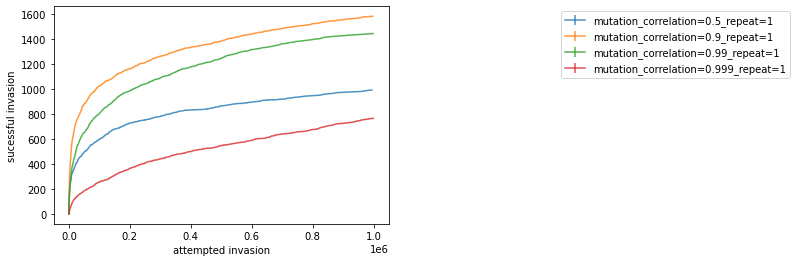

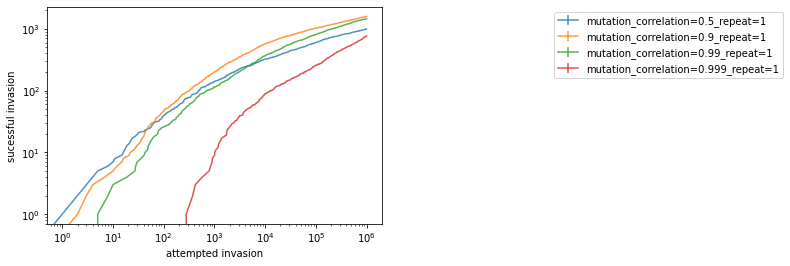

<Figure size 432x288 with 0 Axes>

In [475]:

def sucessful_invasion(analyzer):
    
    return range(len(analyzer.results['successful_index']))
   
plot_2d_results(results_dict, 'successful_index', sucessful_invasion, 'attempted invasion', 'sucessful invasion', xscale='linear', yscale='linear', ax=None, legend=False, group_repeats=True,average_repeats=True)
plot_2d_results(results_dict, 'successful_index', sucessful_invasion, 'attempted invasion', 'sucessful invasion', xscale='log', yscale='log', ax=None, legend=False, group_repeats=True,average_repeats=True)


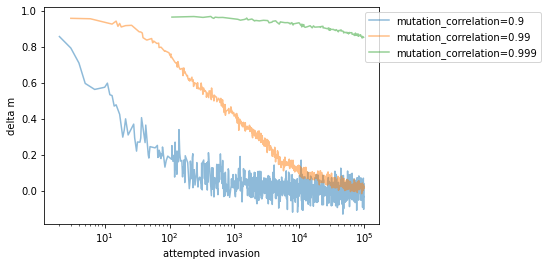

<Figure size 432x288 with 0 Axes>

In [450]:
%matplotlib inline
def deltam(analyzer):
    #print(analyzer.results['List_parentm'])
    return np.ndarray.flatten(np.array(analyzer.results['List_invasionm']))-np.array(analyzer.results['List_parentm'])

plot_2d_results(results_dict, 'successful_index', deltam, 'attempted invasion', 'delta m', xscale='log', yscale='linear', ax=None, legend=False, group_repeats=True)


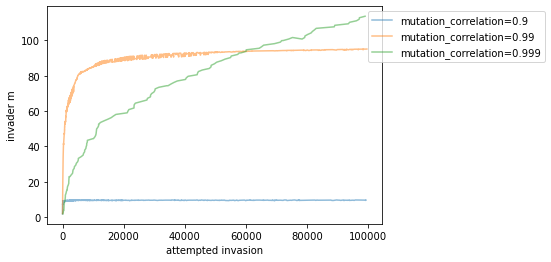

<Figure size 432x288 with 0 Axes>

In [451]:
plot_2d_results(results_dict, 'successful_index', 'List_invasionm', 'attempted invasion', 'invader m', xscale='linear', yscale='linear', ax=None, legend=False, group_repeats=True)


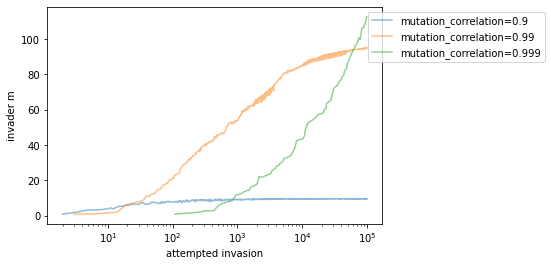

<Figure size 432x288 with 0 Axes>

In [452]:
plot_2d_results(results_dict, 'successful_index', 'List_parentm', 'attempted invasion', 'invader m', xscale='log', yscale='linear', ax=None, legend=False, group_repeats=True)


/Users/zhijie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/zhijie/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


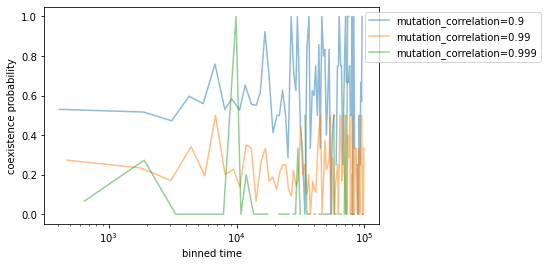

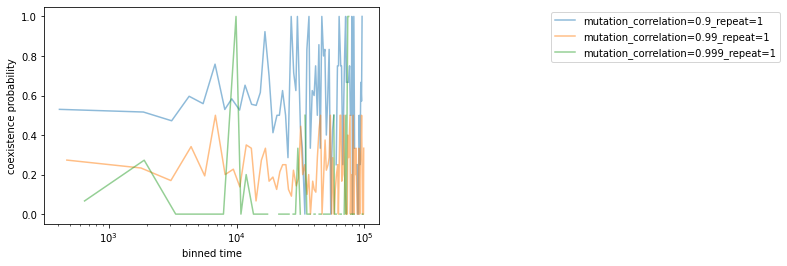

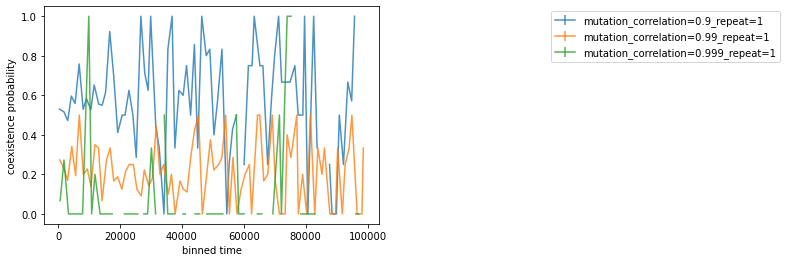

<Figure size 432x288 with 0 Axes>

In [453]:


num_bins=80
binned_times=lambda a: a.get_parent_coexistence_probability(num_bins)[0]
coexistence_probabilitys=lambda a: a.get_parent_coexistence_probability(num_bins)[1]
coexistence_bool=lambda a: a.get_parent_coexistence_bool_list
plot_2d_results(results_dict, binned_times, coexistence_probabilitys, 'binned time', 'coexistence probability', xscale='log', yscale='linear', ax=None, legend=False, group_repeats=True,average_repeats=False)
plot_2d_results(results_dict, binned_times, coexistence_probabilitys, 'binned time', 'coexistence probability', xscale='log', yscale='linear', ax=None, legend=False, group_repeats=False,average_repeats=False)
plot_2d_results(results_dict, binned_times, coexistence_probabilitys, 'binned time', 'coexistence probability', xscale='linear', yscale='linear', ax=None, legend=False, group_repeats=True,average_repeats=True)


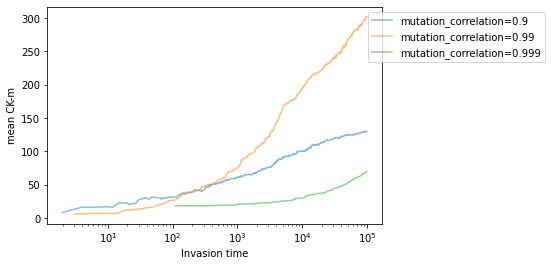

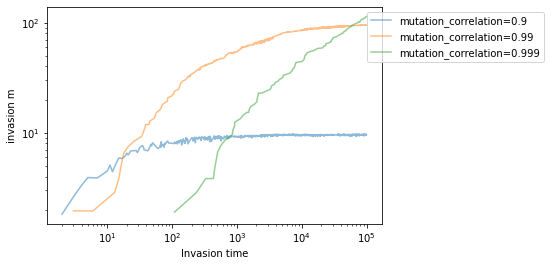

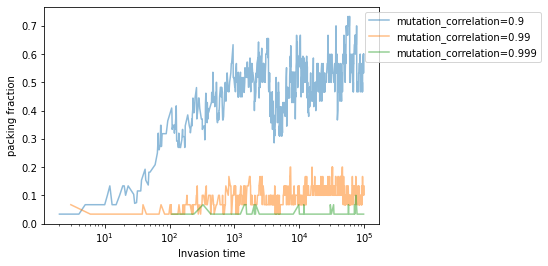

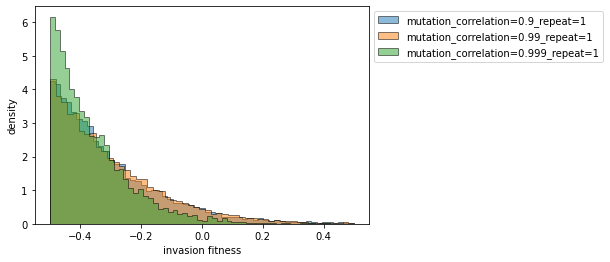

In [454]:
if __name__ == '__main__':
    # Load the saved results    
    results_dict = load_results(filename)

    plot_2d_results(results_dict, 'successful_index','List_meanfitness','Invasion time','mean CK-m',xscale='log',average_repeats=False)
    
    plot_2d_results(results_dict, 'successful_index','List_invasionm','Invasion time','invasion m',xscale='log',yscale='log')

    plot_2d_results(results_dict, 'successful_index','List_packing','Invasion time','packing fraction',xscale='log',yscale='linear')    
    kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins='auto', ec="k",range=[-0.5,0.5])
    plot_histogram_results(results_dict,"List_invasion_fitness", "invasion fitness","density", kwargs)

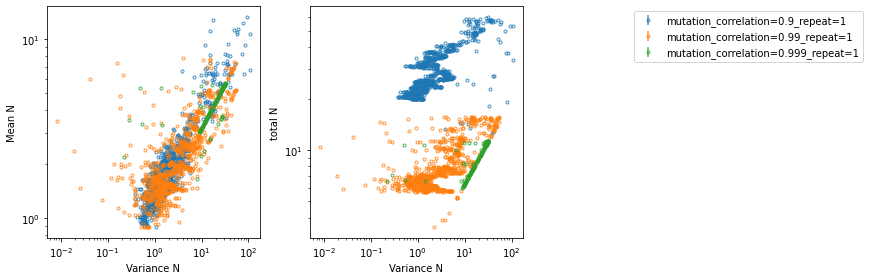

In [455]:
kwargs=dict(marker='o', markerfacecolor='None', markersize=3,linestyle='None')    

x_data_list = [lambda a: a.get_mean_variance_total_N()[1], lambda a: a.get_mean_variance_total_N()[1]]
y_data_list = [lambda a: a.get_mean_variance_total_N()[0], lambda a: a.get_mean_variance_total_N()[2]]
x_label_list = ['Variance N', 'Variance N']
y_label_list = [ 'Mean N','total N']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='log', yscale='log',kwargs=kwargs,average_repeats=True)

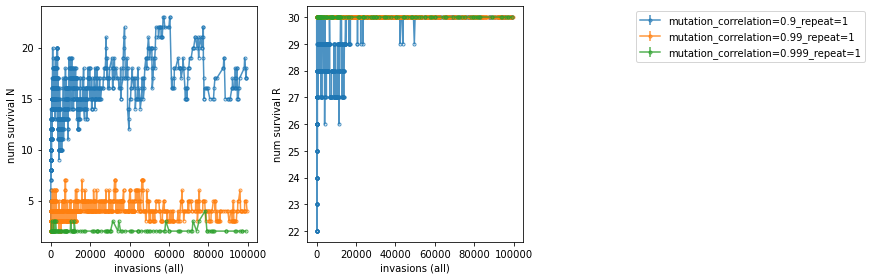

In [456]:
def get_num_N(analyzer):
    result=[]
    listN=analyzer.results['List_N']
    for item in listN:
        result.append(len(item))
    return result

def get_num_R(analyzer):
    result=[]
    list_survival_R=analyzer.results['List_surviveR']
    for item in list_survival_R:
        result.append(sum(item))
    return result
kwargs=dict(marker='o', markerfacecolor='None', markersize=3)    

x_data_list = ['successful_index','successful_index']
y_data_list = [get_num_N, get_num_R]
x_label_list = ['invasions (all)', 'invasions (all)']
y_label_list = [ 'num survival N','num survival R']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list,xscale='linear', yscale='linear', kwargs=kwargs,average_repeats=True)

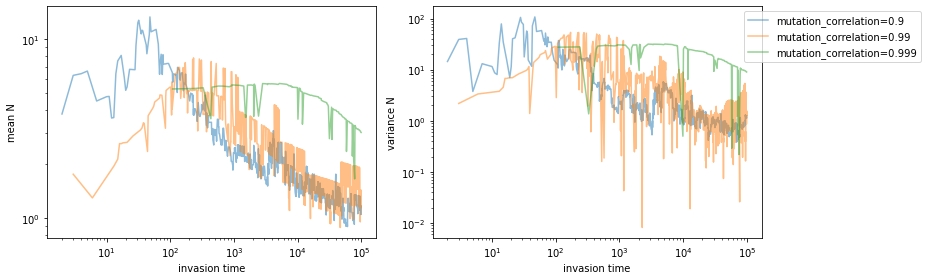

In [457]:

x_data_list = ['successful_index','successful_index']
y_data_list = [lambda a: a.get_mean_variance_total_N()[0], lambda a: a.get_mean_variance_total_N()[1]]
x_label_list = ['invasion time', 'invasion time']
y_label_list = [ 'mean N','variance N']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='log', yscale='log')

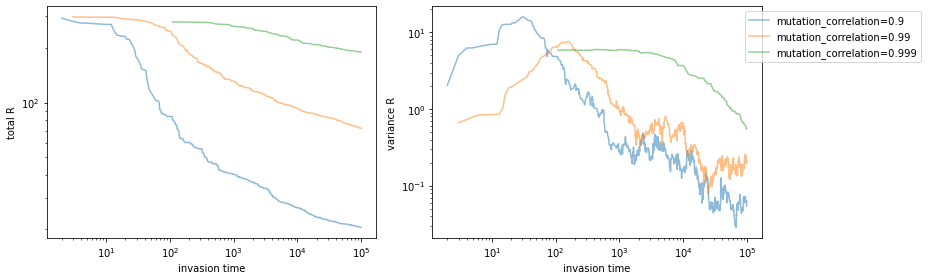

In [458]:

x_data_list = ['successful_index','successful_index']
y_data_list = [lambda a: a.get_mean_variance_total_R()[2], lambda a: a.get_mean_variance_total_R()[1]]
x_label_list = ['invasion time', 'invasion time']
y_label_list = [ 'total R','variance R']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='log', yscale='log')

In [459]:
def mean_variance_nested_list(nested_list):
    list_mean=[]
    list_var=[]
    for List in nested_list:
        list_mean.append(np.mean(List))
        list_var.append(np.var(List))
    return list_mean,list_var

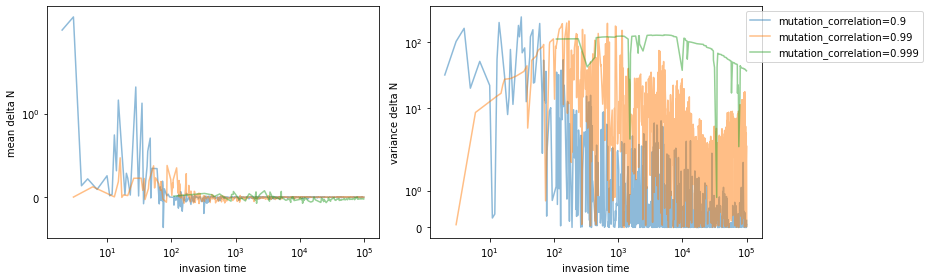

In [460]:
x_data_list = ['successful_index','successful_index']
y_data_list = [lambda a: mean_variance_nested_list(a.get_diff_N_R()[0])[0], lambda a: mean_variance_nested_list(a.get_diff_N_R()[0])[1]]
x_label_list = ['invasion time', 'invasion time']
y_label_list = [ 'mean delta N','variance delta N']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='symlog', yscale='symlog')

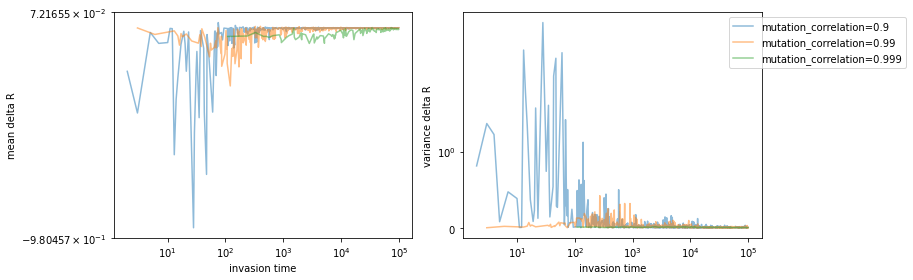

In [461]:
x_data_list = ['successful_index','successful_index']
y_data_list = [lambda a: mean_variance_nested_list(a.get_diff_N_R()[1])[0], lambda a: mean_variance_nested_list(a.get_diff_N_R()[1])[1]]
x_label_list = ['invasion time', 'invasion time']
y_label_list = [ 'mean delta R','variance delta R']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='symlog', yscale='symlog')

In [462]:
#take or remove internal elements of nested lists of unequal length
def take_invader(Nested_List):
    invader=[]
    for List in Nested_List:
        invader.append(List[-1])
    return invader

def remove_invader(Nested_List):
    noninvader=[]
    for List in Nested_List:
        noninvader.append(List[:-1])
    return noninvader    

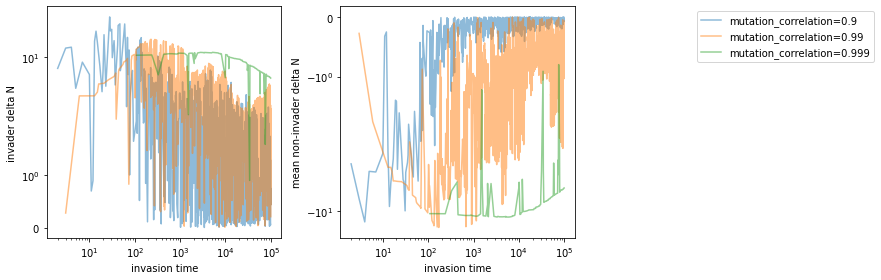

In [463]:
x_data_list = ['successful_index','successful_index']
y_data_list = [lambda a: mean_variance_nested_list(take_invader(a.get_diff_N_R()[0]))[0], lambda a: mean_variance_nested_list(remove_invader(a.get_diff_N_R()[0]))[0]]
x_label_list = ['invasion time', 'invasion time']
y_label_list = [ 'invader delta N','mean non-invader delta N']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='log', yscale='symlog')

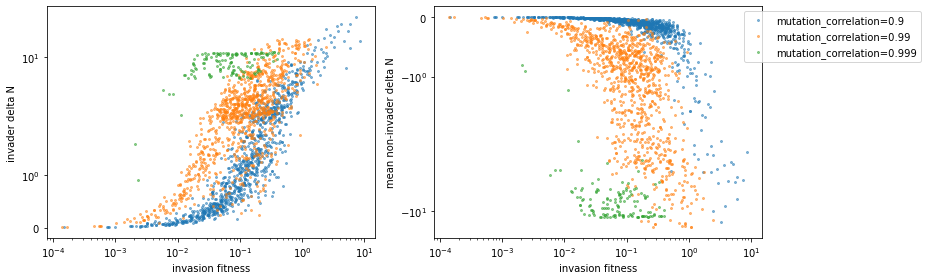

In [464]:
def get_sucessful_invasion_fitness(analyzer):
    all_fitness=analyzer.results['List_invasion_fitness']
    index=analyzer.results['successful_index']
    return np.take(all_fitness,index)
  

kwargs=dict(marker='o', markersize=2, linestyle='None')    
x_data_list = [get_sucessful_invasion_fitness,get_sucessful_invasion_fitness]
y_data_list = [lambda a: mean_variance_nested_list(take_invader(a.get_diff_N_R()[0]))[0], lambda a: mean_variance_nested_list(remove_invader(a.get_diff_N_R()[0]))[0]]
x_label_list = ['invasion fitness', 'invasion fitness']
y_label_list = [ 'invader delta N','mean non-invader delta N']
iterate_and_plot_2d_results(results_dict, x_data_list, y_data_list, x_label_list, y_label_list, xscale='log', yscale='symlog',kwargs=kwargs)



In [471]:

%matplotlib inline

<IPython.core.display.Javascript object>


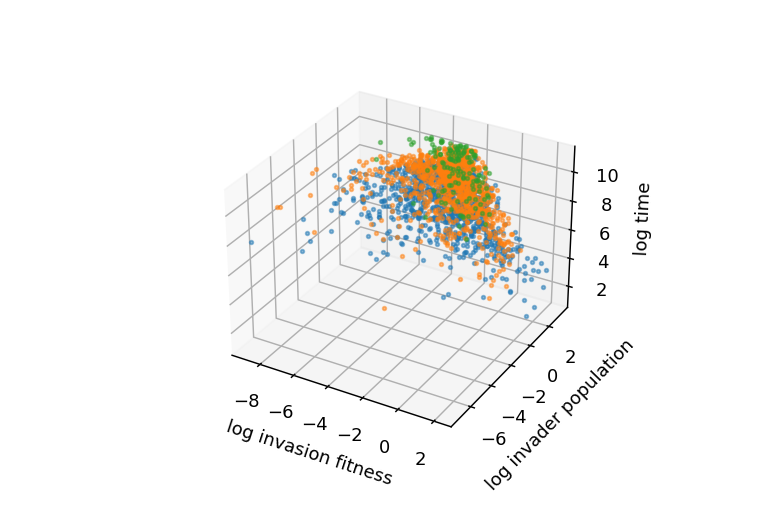

In [466]:
#%matplotlib notebook
def get_log_sucessful_invasion_fitness(analyzer):
    return np.log(get_sucessful_invasion_fitness(analyzer))

def get_log_sucessful_time(analyzer):
    return np.log(analyzer.results['successful_index'])

kwargs=dict(marker='o', markersize=2, linestyle='None') 
plot_3d_results(results_dict, get_log_sucessful_invasion_fitness,lambda a: np.log(mean_variance_nested_list(take_invader(a.get_diff_N_R()[0]))[0]),get_log_sucessful_time,'log invasion fitness','log invader population','log time',kwargs=kwargs,group_repeats=False)
                
                

In [467]:
for param_key, result in results_dict.items():
    print(param_key)

mutation_correlation=0.9_repeat=1
mutation_correlation=0.99_repeat=1
mutation_correlation=0.999_repeat=1


In [468]:
def surviver_C_dot_deltaR_star(analyzer):
    reconstructedC,_,_=analyzer.reconstruct_C_m_k()
    _, deltaR=analyzer.get_diff_N_R()
    result_list=[]
    for i in range(len(reconstructedC)):
        result_list.append((reconstructedC[i]@deltaR[i]))
    print('result is',result_list)    
    return result_list

kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins='auto', ec="k",range=[-1.5,0.5])
plot_histogram_results(results_dict, surviver_C_dot_deltaR_star,  '<C|δR>','frequency',kwargs)
   



result is [array([-5.02988966]), array([-5.89178259]), array([-3.27168246]), array([-9.15933995e-16, -5.12184466e-01]), array([-6.35602682e-15, -1.71251141e+00]), array([-2.88657986e-15, -1.96576895e+00]), array([ 2.28116137e-16, -1.34874750e-15, -1.46406267e-01]), array([ 2.83106871e-15, -1.74860126e-15, -2.37310172e-15, -1.67501241e-01]), array([ 8.88178420e-16, -8.52002223e+00]), array([ 8.88178420e-16, -3.76475574e+00]), array([-1.11022302e-15, -2.95758809e+00]), array([ 1.87350135e-16,  5.05151476e-15, -1.38559188e+00]), array([ 4.99600361e-16, -3.52495810e-15,  2.72004641e-15, -5.77649238e-01]), array([-1.94289029e-16,  8.88178420e-16, -3.88578059e-16, -1.22918524e+00]), array([ 4.27435864e-15, -1.99840144e-15, -2.79619291e+00]), array([-4.53803661e-15,  4.99600361e-16,  9.29811783e-16, -7.60569577e-01]), array([-4.88498131e-15, -2.44249065e-15, -7.45650803e+00]), array([ 6.10622664e-16, -5.48310000e+00]), array([ 3.99680289e-15, -2.44845093e+00]), array([-6.10622664e-16,  2.2204

MemoryError: Unable to allocate 57.8 PiB for an array with shape (8138616388394541,) and data type float64

In [ ]:

fig, axs = plt.subplots(1, 2,figsize=(10, 4))
plt.figure().set_figwidth(20)

axs[ 0].set_title('mean δC')
axs[ 1].set_title('Var δC')


for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index']
        mean_invader_C, var_invader_C = [],[]
        reconstructed_C, reconstructed_m, _=analyzer.reconstruct_C_m_k()
        for i in range(len(reconstructed_C)):
            mean_invader_C.append(np.mean(reconstructed_C[i][-1]))
            var_invader_C.append(np.var(reconstructed_C[i][-1]))
        axs[0].plot(x_values, mean_invader_C, label=param_key)
        axs[1].plot(x_values,var_invader_C, label=param_key)
axs[1].legend(bbox_to_anchor=(1, 1))

In [ ]:

fig, axs = plt.subplots(1, 3,figsize=(10, 3))
plt.figure().set_figwidth(20)

axs[0].set_title('<A^-1δm>')
axs[1].set_title('< δm>')
axs[2].set_title('<δN+ A^-1δm>')


for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index'][1:]
        listinvasionm=result['List_invasionm']
            
        mean_Ainv_deltam = []
        mean_deltam=[]
        reconstructed_C, reconstructed_m, _=analyzer.reconstruct_C_m_k()
        
        Ndiff, Rdiff=analyzer.get_diff_N_R()
        meanNdiff=[]   
            
        for i in range(0,len(reconstructed_C)-1):
            meanNdiff.append(np.mean(Ndiff[i]))
            C=reconstructed_C[i]
            A=C@np.transpose(C)
            Ainv=np.linalg.inv(A)
            #unfinished from here
            deltam=listinvasionm[i]
            
            mean_Ainv_deltam.append(np.mean(np.transpose(Ainv)[-1]*deltam))
            mean_deltam.append(np.mean(deltam))
            
        axs[0].plot(x_values,np.array(mean_Ainv_deltam), label=param_key,alpha=0.5)
        
        axs[1].plot(x_values,np.array(mean_deltam), label=param_key,alpha=0.5)
        axs[2].plot(x_values,(np.array(meanNdiff)+np.array(mean_Ainv_deltam)), label=param_key,alpha=0.5)
        
        axs[0].set_xscale('log')
        axs[1].set_xscale('log')
        axs[2].set_xscale('log')
axs[2].legend(bbox_to_anchor=(1, 1))



In [ ]:

fig, axs = plt.subplots(1, 4,figsize=(20, 4))
plt.figure().set_figwidth(20)

axs[0].set_title('niche averlaps <δC C^T>')
axs[1].set_title('<C>')
axs[2].set_title('<δC>')
#axs[3].set_title('<δC C^T>/<C>/<δC>')
axs[3].set_title('<δC C^T/|δC||C^T|>')

for param_key, result in results_dict.items():
        analyzer = SimulationAnalyzer(result)
        x_values = result['successful_index'][1:]
        listinvasionc=result['List_invasionC']
        reconstructed_C, reconstructed_m, _=analyzer.reconstruct_C_m_k()
        nicheoverlaps=[]
        Caverage=[]
        invasionCaverage=[]
        norm_niches_overlaps=[]
        for i in range(1,len(reconstructed_C)):
            C=reconstructed_C[i][:-1] #C excludes the invader itself
            Caverage.append(np.mean(np.ndarray.flatten(C)))
            nicheoverlaps.append(np.mean(C@listinvasionc[i][0]))
            invasionCaverage.append(np.mean(listinvasionc[i][0]))
            norm_niches_overlaps.append(np.mean(np.array(C@listinvasionc[i][0])/np.linalg.norm(C,axis=1)/np.linalg.norm(listinvasionc[i][0])))
        axs[0].plot(x_values,nicheoverlaps, label=param_key,alpha=0.5)
        axs[1].plot(x_values,Caverage, label=param_key,alpha=0.5)
        axs[2].plot(x_values,invasionCaverage, label=param_key,alpha=0.5)
        
        #axs[3].plot(x_values,np.array(nicheoverlaps)/np.array(Caverage)/np.array(invasionCaverage), label=param_key,alpha=0.5)
        axs[3].plot(x_values,norm_niches_overlaps, label=param_key,alpha=0.5)
        
        
        axs[0].set_xscale('log')
        axs[1].set_xscale('log')
        axs[2].set_xscale('log')
        axs[3].set_xscale('log')
        
        
        
axs[3].legend(bbox_to_anchor=(1, 1))

